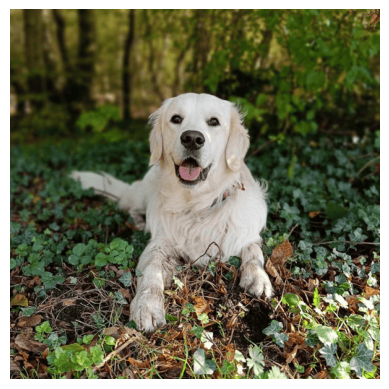

In [1]:
import matplotlib.pyplot as plt

ini_im = plt.imread('Kadoc.png', format='png')[:,:,0:3] # Read the image file
plt.imshow(ini_im)
plt.axis('off')  # Hide the axes
plt.show()  # Display the image

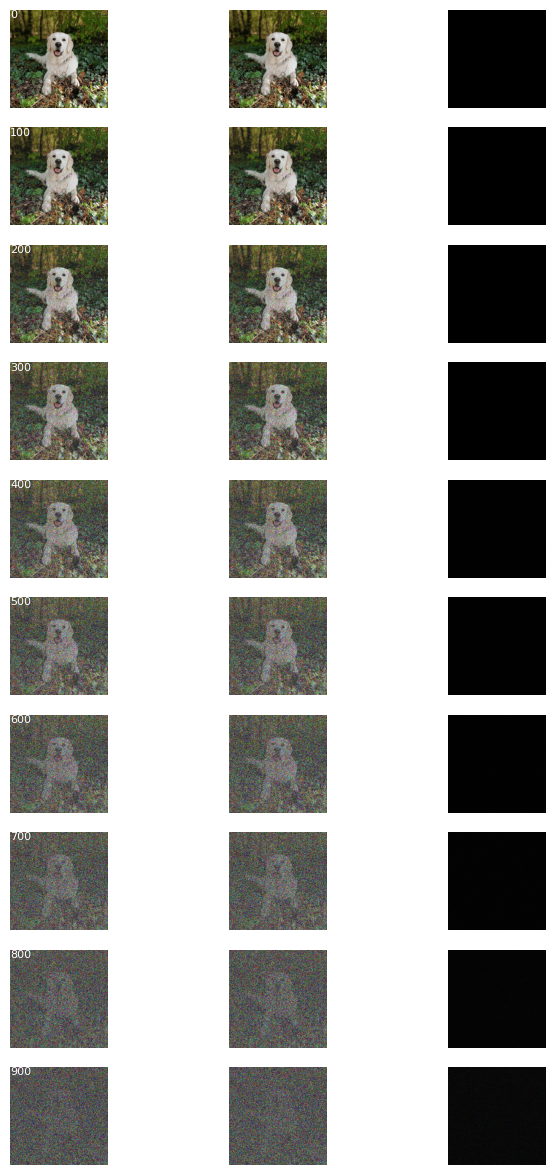

In [5]:
import numpy as np

import torch
from core.schedulers import NoiseScheduler
from core.samplers import DDPMSampler

# Add noise one step at a time
noise_scheduler = NoiseScheduler(
    steps=1000,
    betas=(1e-4, 0.02),
    schedule='cosine',
    seed=42,
    device='cpu'
)
sampler = DDPMSampler(
    noise_scheduler=noise_scheduler
)
generator = torch.Generator().manual_seed(42)

all_images = [] ; all_recovered_images = [] ; all_diffs = []
x = torch.tensor(ini_im)
for i in range(sampler.steps):

    # Noise to add
    noise = torch.randn(x.shape, generator=generator)

    noisy_x = noise_scheduler.add_noise_step(x, i, noise)
    x_rec = sampler.sample_prev_step(noisy_x, i, noise)
    diff = (x - x_rec)**2

    if i % 100 == 0:
        all_images.append(x.numpy())
        all_recovered_images.append(x_rec.numpy())
        all_diffs.append(diff.numpy())

    x = noisy_x  # Update x to the noisy image for the next iteration

v_min = torch.min(diff)
v_max = torch.max(diff)

# Plot the initial image and the recovered images side by side
fig, axs = plt.subplots(noise_scheduler.steps // 100, 3, figsize=(8, 15))
for i, (im, rec_im, diff) in enumerate(zip(all_images, all_recovered_images, all_diffs)):

    axs[i,0].imshow(np.clip(im, 0, 1), vmin=0, vmax=1)
    axs[i,0].axis('off')
    axs[i,0].text(0.5, 0.5, str(i * 100), color='white', fontsize=8, ha='left', va='top')
    axs[i,1].imshow(np.clip(rec_im, 0, 1), vmin=0, vmax=1)
    axs[i,1].axis('off')
    axs[i,2].imshow(diff, vmin=v_min, vmax=v_max, cmap='hot')
    axs[i,2].axis('off')
plt.show()


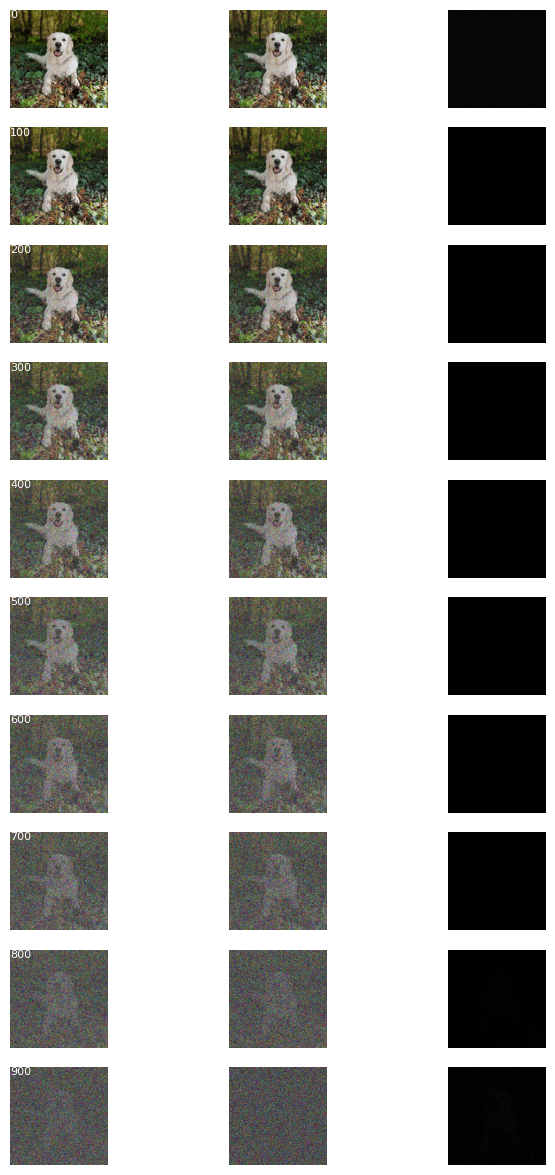

In [6]:
import numpy as np

import torch
from core.schedulers import NoiseScheduler
from core.samplers import DDIMSampler

# Add noise one step at a time
noise_scheduler = NoiseScheduler(
    steps=1000,
    betas=(1e-4, 0.02),
    schedule='cosine',
    seed=42,
    device='cpu'
)
sampler = DDIMSampler(
    noise_scheduler=noise_scheduler,
    steps=10,
    eta=0.1, # No noise added in DDIM
)
generator = torch.Generator().manual_seed(42)

all_images = [] ; all_recovered_images = [] ; all_diffs = []
x = torch.tensor(ini_im)
for i in range(sampler.steps):

    # Noise to add
    noise = torch.randn(x.shape, generator=generator)

    if i == 0:
        x_ref = x.clone()
    else:
        x_ref = noise_scheduler.add_noise_cumulative(torch.tensor(ini_im), i*100-1, noise)

    noisy_x = noise_scheduler.add_noise_cumulative(torch.tensor(ini_im), (i+1)*100-1, noise)
    x_rec = sampler.sample_prev_step(noisy_x, i, noise)
    diff = (x_ref - x_rec)**2

    all_images.append(x_ref.numpy())
    all_recovered_images.append(x_rec.numpy())
    all_diffs.append(diff.numpy())

vmin = torch.min(diff)
vmax = torch.max(diff)

# Plot the initial image and the recovered images side by side
fig, axs = plt.subplots(sampler.steps, 3, figsize=(8, 15))
for i, (im, rec_im, diff) in enumerate(zip(all_images, all_recovered_images, all_diffs)):

    axs[i,0].imshow(np.clip(im, 0, 1), vmin=0, vmax=1)
    axs[i,0].axis('off')
    axs[i,0].text(0.5, 0.5, str(i * 100), color='white', fontsize=8, ha='left', va='top')
    axs[i,1].imshow(np.clip(rec_im, 0, 1), vmin=0, vmax=1)
    axs[i,1].axis('off')
    axs[i,2].imshow(diff, vmin=vmin, vmax=vmax, cmap='hot')
    axs[i,2].axis('off')
plt.show()
